# Atividade II: Regularizadores e Otimizadores

**Descrição:**
- Usando o código previamente desenvolvido, verifique se a mudança de otimizadores produz melhores resultados. 
- Teste pelo menos 2 otimizadores além do utilizado na **Atividade I**. 
- Em seguida, adicione regularizadores ao experimento (Teste dropout e penalidades). 
- Use testes estatísticos para mostrar se a diferença é significativa ou não.


*Este notebook foi criado por [Adrielson Ferreira Justino]*

*Para qualquer feedback, erro ou sugestão, ele pode ser contatado por e-mail (adrielferreira28@gmail.com), [GIT](https://github.com/Adrielson) ou [LinkedIn](https://www.linkedin.com/in/adrielson-justino).*

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping

In [2]:
# 2. Carregamento e Análise Inicial dos Dados
df = pd.read_csv('archive/data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
# df.info()

In [4]:
df.drop(['id', 'Unnamed: 32'], axis = 1, inplace = True)

In [5]:
df.diagnosis.unique()

array(['M', 'B'], dtype=object)

In [6]:
# df.describe()

In [7]:
# df.columns

In [8]:
# df.isna().sum()

In [9]:
# msno.bar(df)

In [10]:
# plt.figure(figsize=(20, 15))
# plotnumber = 1

# for column in df:
#     if plotnumber <= 30 and pd.api.types.is_numeric_dtype(df[column]):
#         ax = plt.subplot(5, 6, plotnumber)
#         sns.histplot(df[column], kde=True)
#         plt.xlabel(column)
#         plotnumber += 1

# plt.tight_layout()
# plt.show()

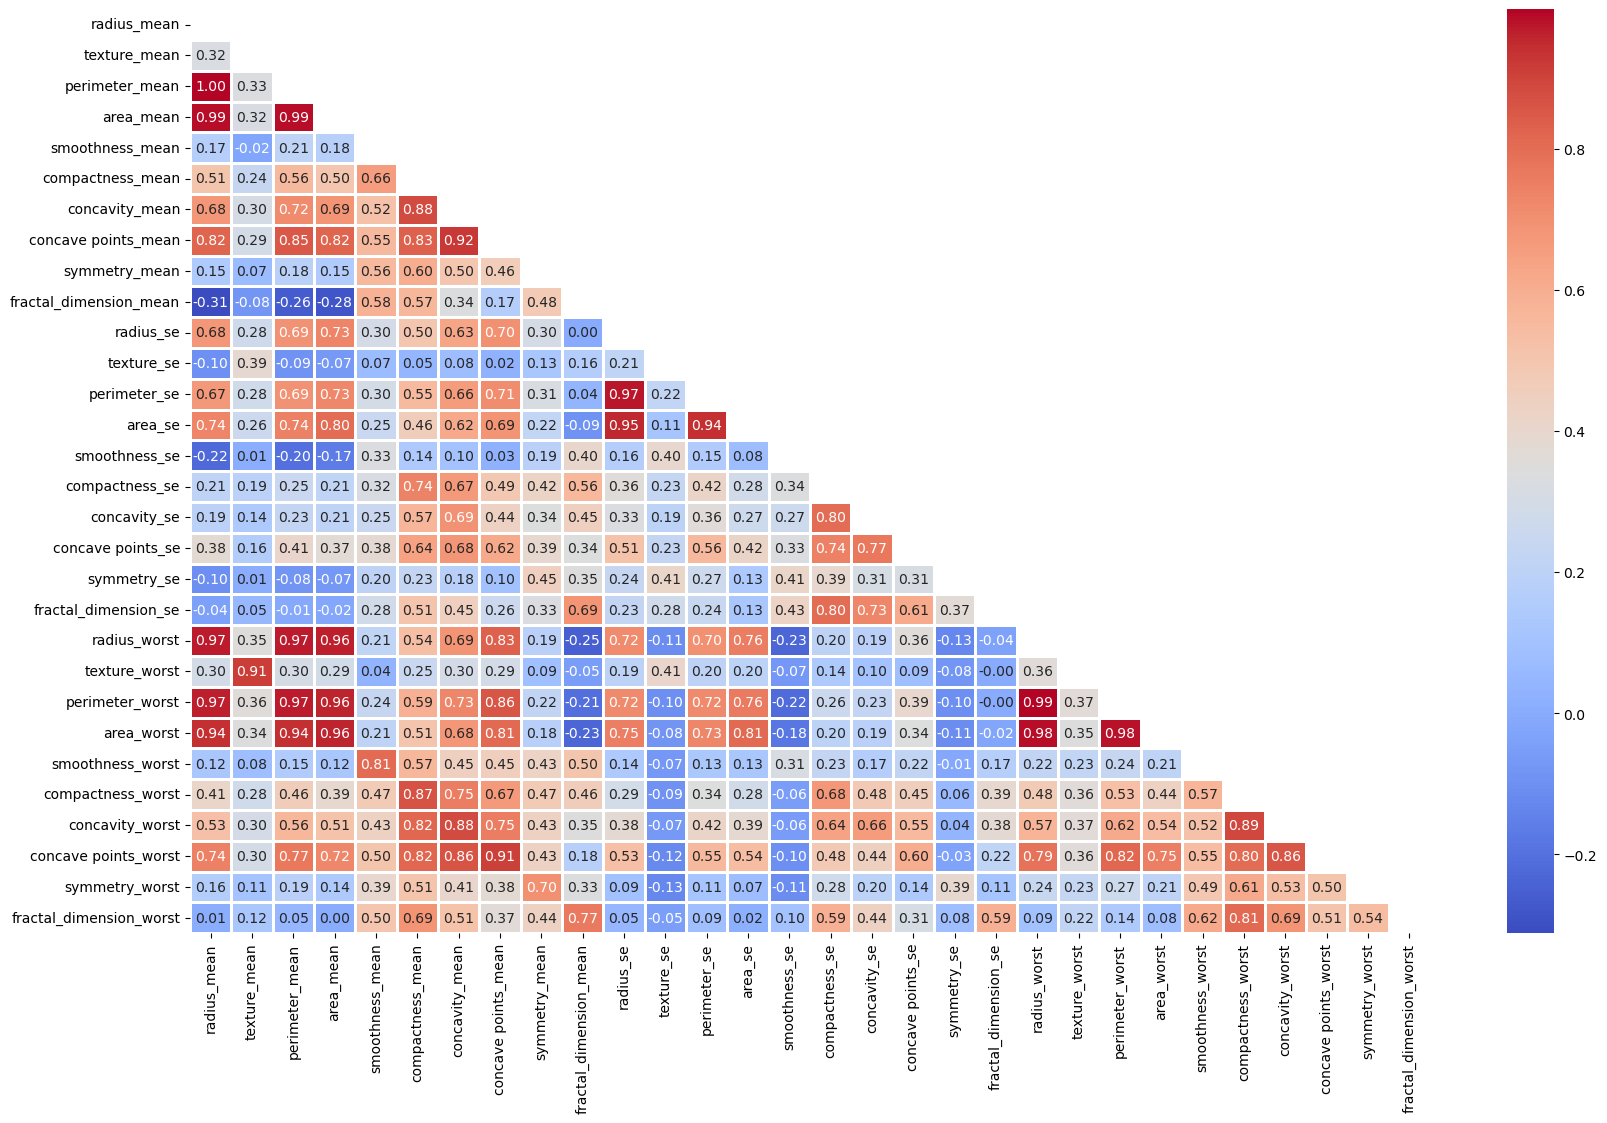

In [12]:
numeric_df = df.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr = numeric_df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(20, 12))

# Draw the heatmap
sns.heatmap(corr, mask=mask, linewidths=1, annot=True, fmt=".2f", cmap="coolwarm")

# Show the plot
plt.show()

In [13]:
corr_matrix = numeric_df.corr().abs()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

tri_df = corr_matrix.mask(mask)

to_drop = [x for x in tri_df.columns if any(tri_df[x] > 0.92)]

df = df.drop(to_drop, axis=1)

print(f"O data frame reduzido tem {df.shape[1]} colunas.")


O data frame reduzido tem 23 colunas.


In [14]:
X = df.drop('diagnosis', axis = 1)
y = df['diagnosis']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [16]:
# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [17]:
# Codificar os rótulos (diagnósticos malignos ou benignos) como 0 e 1
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# 1. Multilayer Perceptron (MLP)
### 1.1 Modelo MLP com Adam (sem regularizador)


In [18]:
mlp_model_1 = Sequential()
mlp_model_1.add(Input(shape=(X_train.shape[1],)))
mlp_model_1.add(Dense(64, activation='relu'))
mlp_model_1.add(Dense(32, activation='relu'))
mlp_model_1.add(Dense(1, activation='sigmoid'))

# Compilar com Adam
mlp_model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop_1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Treinar
mlp_history_1 = mlp_model_1.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                                validation_data=(X_test, y_test_encoded), callbacks=[early_stop_1])

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4935 - loss: 3.3297 - val_accuracy: 0.3860 - val_loss: 1.0149
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5221 - loss: 0.8298 - val_accuracy: 0.4912 - val_loss: 0.8920
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5367 - loss: 0.7715 - val_accuracy: 0.7602 - val_loss: 0.5147
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7833 - loss: 0.5375 - val_accuracy: 0.6082 - val_loss: 0.7113
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7215 - loss: 0.5692 - val_accuracy: 0.7368 - val_loss: 0.6178
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6980 - loss: 0.6676 - val_accuracy: 0.7836 - val_loss: 0.4934
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7876 - loss: 0.4820 - val_accuracy: 0.7544 - val_loss: 0.4608
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7892 - loss: 0.4789 - val_accuracy: 0.7427 - 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Accuracy_1: 0.8713450292397661
Precision_1: 0.8253968253968254
Recall_1: 0.8253968253968254
F1 Score_1: 0.8253968253968254


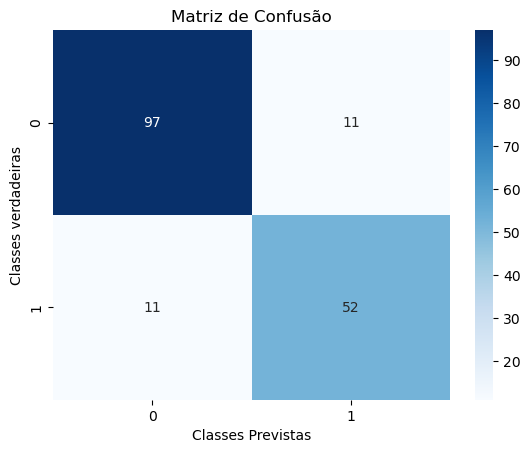

In [19]:
# Avaliar e prever
y_pred_1 = (mlp_model_1.predict(X_test) > 0.5).astype("int32")
accuracy_1 = accuracy_score(y_test_encoded, y_pred_1)
precision_1 = precision_score(y_test_encoded, y_pred_1)
recall_1 = recall_score(y_test_encoded, y_pred_1)
f1_1 = f1_score(y_test_encoded, y_pred_1)

# Exibir as métricas
print("Accuracy_1:", accuracy_1)
print("Precision_1:", precision_1)
print("Recall_1:", recall_1)
print("F1 Score_1:", f1_1)

# Matriz de confusão
cm = confusion_matrix(y_test_encoded, y_pred_1)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Classes Previstas')
plt.ylabel('Classes verdadeiras')
plt.show()

### 1.2. Modelo MLP com SGD (sem regularizadores)

In [20]:
from keras.optimizers import SGD

mlp_model_2 = Sequential()
mlp_model_2.add(Input(shape=(X_train.shape[1],)))
mlp_model_2.add(Dense(64, activation='relu'))
mlp_model_2.add(Dense(32, activation='relu'))
mlp_model_2.add(Dense(1, activation='sigmoid'))

# Compilar com SGD
mlp_model_2.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

early_stop_2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Treinar
mlp_history_2 = mlp_model_2.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                                validation_data=(X_test, y_test_encoded), callbacks=[early_stop_2])


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5329 - loss: 2373.1133 - val_accuracy: 0.6316 - val_loss: 0.6880
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6267 - loss: 0.6851 - val_accuracy: 0.6316 - val_loss: 0.6751
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6183 - loss: 0.6751 - val_accuracy: 0.6316 - val_loss: 0.6667
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6368 - loss: 0.6638 - val_accuracy: 0.6316 - val_loss: 0.6617
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5950 - loss: 0.6749 - val_accuracy: 0.6316 - val_loss: 0.6603
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6383 - loss: 0.6573 - val_accuracy: 0.6316 - val_loss: 0.6590
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6178 - loss: 0.6652 - val_accuracy: 0.6316 - val_loss: 0.6586
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6039 - loss: 0.6718 - val_accuracy: 0.6316

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy_2: 0.3684210526315789
Precision_2: 0.3684210526315789
Recall_2: 1.0
F1 Score_2: 0.5384615384615384


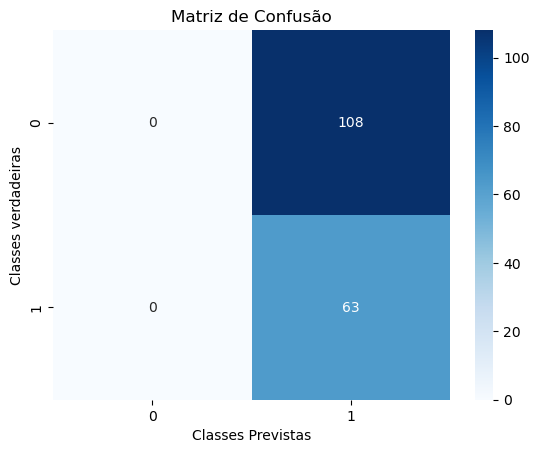

In [22]:
# Avaliar e prever
y_pred_2 = (mlp_model_2.predict(X_test) > 0.3).astype("int32")
accuracy_2 = accuracy_score(y_test_encoded, y_pred_2)
precision_2 = precision_score(y_test_encoded, y_pred_2, zero_division=1)
recall_2 = recall_score(y_test_encoded, y_pred_2)
f1_2 = f1_score(y_test_encoded, y_pred_2)

# Exibir as métricas
print("Accuracy_2:", accuracy_2)
print("Precision_2:", precision_2)
print("Recall_2:", recall_2)
print("F1 Score_2:", f1_2)

# Matriz de confusão
cm = confusion_matrix(y_test_encoded, y_pred_2)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Classes Previstas')
plt.ylabel('Classes verdadeiras')
plt.show()

In [ ]:
unique, counts = np.unique(y_pred_2, return_counts=True)
print(f"Previsões únicas: {dict(zip(unique, counts))}")

### 1.3. MLP com RMSprop (sem regularizadores)

In [23]:
from keras.optimizers import RMSprop

mlp_model_3 = Sequential()
mlp_model_3.add(Input(shape=(X_train.shape[1],)))
mlp_model_3.add(Dense(64, activation='relu'))
mlp_model_3.add(Dense(32, activation='relu'))
mlp_model_3.add(Dense(1, activation='sigmoid'))

# Compilar com RMSprop
mlp_model_3.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stop_3 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Treinar
mlp_history_3 = mlp_model_3.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                                validation_data=(X_test, y_test_encoded), callbacks=[early_stop_3])

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5169 - loss: 8.8880 - val_accuracy: 0.5789 - val_loss: 1.1004
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5043 - loss: 2.4080 - val_accuracy: 0.3743 - val_loss: 4.8501
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4662 - loss: 3.6832 - val_accuracy: 0.6316 - val_loss: 3.1158
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4735 - loss: 4.0940 - val_accuracy: 0.6316 - val_loss: 2.2390
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5910 - loss: 2.4739 - val_accuracy: 0.6316 - val_loss: 1.7436
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5436 - loss: 3.2845 - val_accuracy: 0.7544 - val_loss: 0.6782
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5654 - loss: 2.1727 - val_accuracy: 0.6316 - val_loss: 0.7785
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5542 - loss: 2.4523 - val_accuracy: 0.5789

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Accuracy_3: 0.4152046783625731
Precision_3: 0.38650306748466257
Recall_3: 1.0
F1 Score_3: 0.5575221238938053


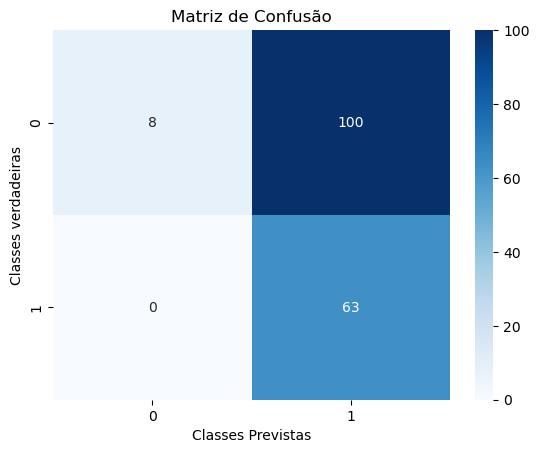

In [24]:
# Avaliar e prever
y_pred_3 = (mlp_model_3.predict(X_test) > 0.5).astype("int32")
accuracy_3 = accuracy_score(y_test_encoded, y_pred_3)
precision_3 = precision_score(y_test_encoded, y_pred_3, zero_division=1)
recall_3 = recall_score(y_test_encoded, y_pred_3)
f1_3 = f1_score(y_test_encoded, y_pred_3)

# Exibir as métricas
print("Accuracy_3:", accuracy_3)
print("Precision_3:", precision_3)
print("Recall_3:", recall_3)
print("F1 Score_3:", f1_3)

# Matriz de confusão
cm = confusion_matrix(y_test_encoded, y_pred_3)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Classes Previstas')
plt.ylabel('Classes verdadeiras')
plt.show()

### 1.4. Modelo MLP com Adam + Dropout

In [25]:
from keras.layers import Dropout

mlp_model_4 = Sequential()
mlp_model_4.add(Input(shape=(X_train.shape[1],)))
mlp_model_4.add(Dense(64, activation='relu'))
mlp_model_4.add(Dropout(0.3))
mlp_model_4.add(Dense(32, activation='relu'))
mlp_model_4.add(Dropout(0.3))
mlp_model_4.add(Dense(1, activation='sigmoid'))

# Compilar com Adam
mlp_model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop_4 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Treinar
mlp_history_4 = mlp_model_4.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                                validation_data=(X_test, y_test_encoded), callbacks=[early_stop_4])

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5325 - loss: 31.9766 - val_accuracy: 0.3684 - val_loss: 18.7887
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4917 - loss: 31.6816 - val_accuracy: 0.3684 - val_loss: 9.2527
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4425 - loss: 32.5214 - val_accuracy: 0.3684 - val_loss: 9.7769
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4902 - loss: 21.8227 - val_accuracy: 0.3918 - val_loss: 2.6391
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4778 - loss: 19.2584 - val_accuracy: 0.6842 - val_loss: 1.6535
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5568 - loss: 12.8963 - val_accuracy: 0.3860 - val_loss: 2.3930
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4780 - loss: 12.3380 - val_accuracy: 0.4971 - val_loss: 1.2920
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5156 - loss: 12.8883 - val_accuracy: 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy_4: 0.9064327485380117
Precision_4: 0.8852459016393442
Recall_4: 0.8571428571428571
F1 Score_4: 0.8709677419354839


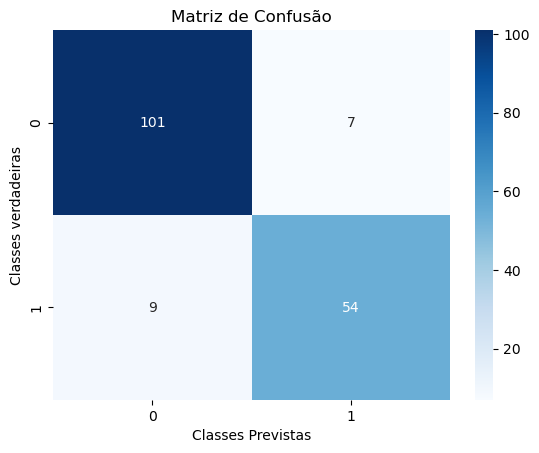

In [26]:
# Avaliar e prever
y_pred_4 = (mlp_model_4.predict(X_test) > 0.5).astype("int32")
accuracy_4 = accuracy_score(y_test_encoded, y_pred_4)
precision_4 = precision_score(y_test_encoded, y_pred_4, zero_division=1)
recall_4 = recall_score(y_test_encoded, y_pred_4)
f1_4 = f1_score(y_test_encoded, y_pred_4)

# Exibir as métricas
print("Accuracy_4:", accuracy_4)
print("Precision_4:", precision_4)
print("Recall_4:", recall_4)
print("F1 Score_4:", f1_4)

# Matriz de confusão
cm = confusion_matrix(y_test_encoded, y_pred_4)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Classes Previstas')
plt.ylabel('Classes verdadeiras')
plt.show()

### 1.5. Modelo MLP com Adam + L2 Regularization

In [27]:
from keras.regularizers import l2

mlp_model_5 = Sequential()
mlp_model_5.add(Input(shape=(X_train.shape[1],)))
mlp_model_5.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
mlp_model_5.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
mlp_model_5.add(Dense(1, activation='sigmoid'))

# Compilar com Adam
mlp_model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop_5 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Treinar
mlp_history_5 = mlp_model_5.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                                validation_data=(X_test, y_test_encoded), callbacks=[early_stop_5])

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4332 - loss: 10.1185 - val_accuracy: 0.5146 - val_loss: 2.1357
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6518 - loss: 1.9574 - val_accuracy: 0.7076 - val_loss: 1.7022
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7866 - loss: 1.2172 - val_accuracy: 0.8070 - val_loss: 0.9891
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8285 - loss: 0.9518 - val_accuracy: 0.8480 - val_loss: 0.9269
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8328 - loss: 0.9177 - val_accuracy: 0.7895 - val_loss: 1.0897
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7478 - loss: 1.1064 - val_accuracy: 0.7076 - val_loss: 1.0497
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7834 - loss: 0.9258 - val_accuracy: 0.8187 - val_loss: 0.9098
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8077 - loss: 0.8222 - val_accuracy: 0.7836 -

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy_5: 0.8421052631578947
Precision_5: 0.7307692307692307
Recall_5: 0.9047619047619048
F1 Score_5: 0.8085106382978723


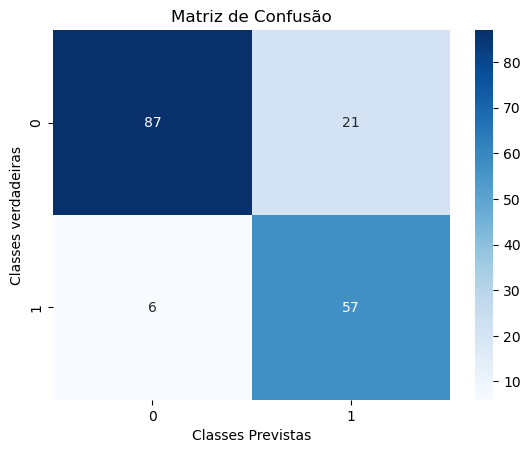

In [36]:
# Avaliar e prever
y_pred_5 = (mlp_model_5.predict(X_test) > 0.5).astype("int32")
accuracy_5 = accuracy_score(y_test_encoded, y_pred_5)
precision_5 = precision_score(y_test_encoded, y_pred_5, zero_division=1)
recall_5 = recall_score(y_test_encoded, y_pred_5)
f1_5 = f1_score(y_test_encoded, y_pred_5)

# Exibir as métricas
print("Accuracy_5:", accuracy_5)
print("Precision_5:", precision_5)
print("Recall_5:", recall_5)
print("F1 Score_5:", f1_5)

# Matriz de confusão
cm = confusion_matrix(y_test_encoded, y_pred_5)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Classes Previstas')
plt.ylabel('Classes verdadeiras')
plt.show()


### 1.6. Modelo MLP com SGD + Dropout

In [29]:
mlp_model_6 = Sequential()
mlp_model_6.add(Input(shape=(X_train.shape[1],)))
mlp_model_6.add(Dense(64, activation='relu'))
mlp_model_6.add(Dropout(0.3))
mlp_model_6.add(Dense(32, activation='relu'))
mlp_model_6.add(Dropout(0.3))
mlp_model_6.add(Dense(1, activation='sigmoid'))

# Compilar com SGD
mlp_model_6.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

early_stop_6 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Treinar
mlp_history_6 = mlp_model_6.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                                validation_data=(X_test, y_test_encoded), callbacks=[early_stop_6])


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5561 - loss: 1280.0763 - val_accuracy: 0.6316 - val_loss: 0.6630
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6280 - loss: 0.6692 - val_accuracy: 0.6316 - val_loss: 0.6599
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6232 - loss: 0.6737 - val_accuracy: 0.6316 - val_loss: 0.6584
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6111 - loss: 0.6784 - val_accuracy: 0.6316 - val_loss: 0.6614
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6274 - loss: 0.6650 - val_accuracy: 0.6316 - val_loss: 0.6589
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6456 - loss: 0.6496 - val_accuracy: 0.6316 - val_loss: 0.6653
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6410 - loss: 0.6612 - val_accuracy: 0.6316 - val_loss: 0.6585
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6363 - loss: 0.6562 - val_accuracy: 0.6316

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy_6: 0.631578947368421
Precision_6: 1.0
Recall_6: 0.0
F1 Score_6: 0.0


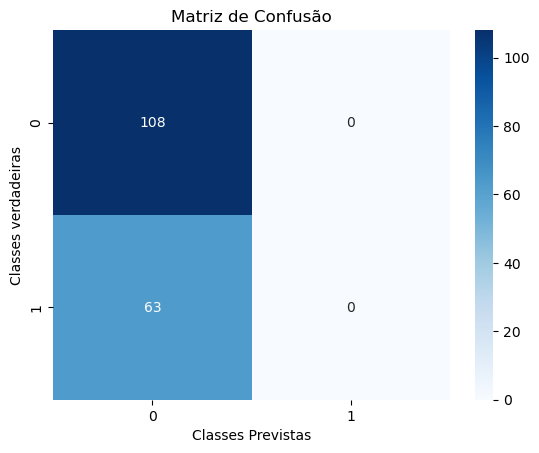

In [37]:
# Avaliar e prever
y_pred_6 = (mlp_model_6.predict(X_test) > 0.5).astype("int32")
accuracy_6 = accuracy_score(y_test_encoded, y_pred_6)
precision_6 = precision_score(y_test_encoded, y_pred_6, zero_division=1)
recall_6 = recall_score(y_test_encoded, y_pred_6)
f1_6 = f1_score(y_test_encoded, y_pred_6)

# Exibir as métricas
print("Accuracy_6:", accuracy_6)
print("Precision_6:", precision_6)
print("Recall_6:", recall_6)
print("F1 Score_6:", f1_6)

# Matriz de confusão
cm = confusion_matrix(y_test_encoded, y_pred_6)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Classes Previstas')
plt.ylabel('Classes verdadeiras')
plt.show()


### 1.7. MLP com SGD + L2 Regularization

In [31]:
mlp_model_7 = Sequential()
mlp_model_7.add(Input(shape=(X_train.shape[1],)))
mlp_model_7.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
mlp_model_7.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
mlp_model_7.add(Dense(1, activation='sigmoid'))

# Compilar com SGD
mlp_model_7.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

early_stop_7 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Treinar
mlp_history_7 = mlp_model_7.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                                validation_data=(X_test, y_test_encoded), callbacks=[early_stop_7])



Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5585 - loss: 33037.2383 - val_accuracy: 0.6316 - val_loss: 112333.9531
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6123 - loss: 144921.7812 - val_accuracy: 0.6316 - val_loss: 214143.2500
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6192 - loss: 222618.0312 - val_accuracy: 0.6316 - val_loss: 236431.8906
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6288 - loss: 236432.4531 - val_accuracy: 0.6316 - val_loss: 233106.2500
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5985 - loss: 230904.9531 - val_accuracy: 0.6316 - val_loss: 223353.6562
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6393 - loss: 220695.4844 - val_accuracy: 0.6316 - val_loss: 212401.4062
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6112 - loss: 209734.7656 - val_accuracy: 0.6316 - val_loss: 201580.0938
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6202 - loss: 22634.7285 - val_accuracy: 0.6316 - val_loss: 21743.9395
Epoch 50/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6268 - loss: 21465.7695 - val_accuracy: 0.6316 - val_loss: 20620.9863
Epoch 51/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6355 - loss: 20357.1797 - val_accuracy: 0.6316 - val_loss: 19556.0273
Epoch 52/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5837 - loss: 19305.8711 - val_accuracy: 0.6316 - val_loss: 18546.0742
Epoch 53/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6331 - loss: 18308.8105 - val_accuracy: 0.6316 - val_loss: 17588.2812
Epoch 54/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6315 - loss: 17363.2715 - val_accuracy: 0.6316 - val_loss: 16679.9512
Epoch 55/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6314 - loss: 16466.5605 - val_accuracy: 0.6316 - val_loss: 15818.5303
Epoch 56/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accurac

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy_7: 0.631578947368421
Precision_7: 1.0
Recall_7: 0.0
F1 Score_7: 0.0


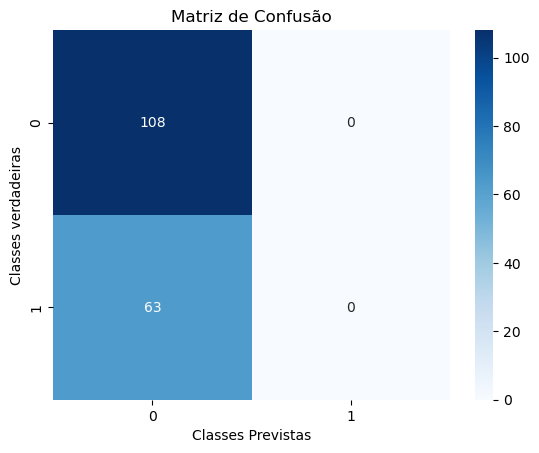

In [41]:
# Avaliar e prever
y_pred_7 = (mlp_model_7.predict(X_test) > 0.5).astype("int32")
accuracy_7 = accuracy_score(y_test_encoded, y_pred_7)
precision_7 = precision_score(y_test_encoded, y_pred_7, zero_division=1)
recall_7 = recall_score(y_test_encoded, y_pred_7)
f1_7 = f1_score(y_test_encoded, y_pred_7)

# Exibir as métricas
print("Accuracy_7:", accuracy_7)
print("Precision_7:", precision_7)
print("Recall_7:", recall_7)
print("F1 Score_7:", f1_7)

# Matriz de confusão
cm = confusion_matrix(y_test_encoded, y_pred_7)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Classes Previstas')
plt.ylabel('Classes verdadeiras')
plt.show()


### 1.8. Modelo MLP com RMSprop + Dropout

In [32]:
mlp_model_8 = Sequential()
mlp_model_8.add(Input(shape=(X_train.shape[1],)))
mlp_model_8.add(Dense(64, activation='relu'))
mlp_model_8.add(Dropout(0.3))
mlp_model_8.add(Dense(32, activation='relu'))
mlp_model_8.add(Dropout(0.3))
mlp_model_8.add(Dense(1, activation='sigmoid'))

# Compilar com RMSprop
mlp_model_8.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stop_8 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Treinar
mlp_history_8 = mlp_model_8.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                                validation_data=(X_test, y_test_encoded), callbacks=[early_stop_8])



Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4053 - loss: 75.3158 - val_accuracy: 0.3684 - val_loss: 40.8298
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4821 - loss: 36.0021 - val_accuracy: 0.3684 - val_loss: 16.5778
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4021 - loss: 37.7483 - val_accuracy: 0.3684 - val_loss: 12.7483
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4502 - loss: 29.4979 - val_accuracy: 0.3743 - val_loss: 6.5586
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4731 - loss: 23.3730 - val_accuracy: 0.3684 - val_loss: 11.1925
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4782 - loss: 19.1340 - val_accuracy: 0.4211 - val_loss: 4.4845
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4798 - loss: 17.4840 - val_accuracy: 0.3743 - val_loss: 5.2574
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4939 - loss: 13.4221 - val_accurac

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy_8: 0.7134502923976608
Precision_8: 0.5625
Recall_8: 1.0
F1 Score_8: 0.72


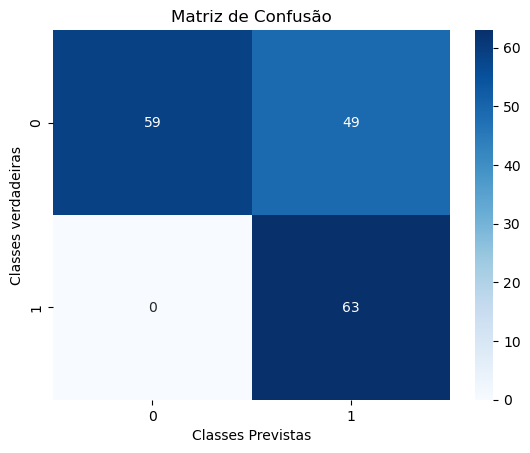

In [38]:
# Avaliar e prever
y_pred_8 = (mlp_model_8.predict(X_test) > 0.5).astype("int32")
accuracy_8 = accuracy_score(y_test_encoded, y_pred_8)
precision_8 = precision_score(y_test_encoded, y_pred_8, zero_division=1)
recall_8 = recall_score(y_test_encoded, y_pred_8)
f1_8 = f1_score(y_test_encoded, y_pred_8)

# Exibir as métricas
print("Accuracy_8:", accuracy_8)
print("Precision_8:", precision_8)
print("Recall_8:", recall_8)
print("F1 Score_8:", f1_8)

# Matriz de confusão
cm = confusion_matrix(y_test_encoded, y_pred_8)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Classes Previstas')
plt.ylabel('Classes verdadeiras')
plt.show()


### 1.9. Modelo MLP com RMSprop + L2 Regularization

In [34]:
mlp_model_9 = Sequential()
mlp_model_9.add(Input(shape=(X_train.shape[1],)))
mlp_model_9.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
mlp_model_9.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
mlp_model_9.add(Dense(1, activation='sigmoid'))

# Compilar com RMSprop
mlp_model_9.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stop_9 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Treinar
mlp_history_9 = mlp_model_9.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                                validation_data=(X_test, y_test_encoded), callbacks=[early_stop_9])



Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5343 - loss: 47.6847 - val_accuracy: 0.3860 - val_loss: 2.0431
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4919 - loss: 4.9460 - val_accuracy: 0.6316 - val_loss: 3.8505
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5061 - loss: 5.2525 - val_accuracy: 0.4094 - val_loss: 2.8156
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5693 - loss: 3.2235 - val_accuracy: 0.6316 - val_loss: 6.3046
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5688 - loss: 4.3943 - val_accuracy: 0.4035 - val_loss: 3.4960
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4573 - loss: 4.7081 - val_accuracy: 0.3684 - val_loss: 8.3351
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5334 - loss: 4.2366 - val_accuracy: 0.8246 - val_loss: 0.9218
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7084 - loss: 2.4101 - val_accuracy: 0.7076 -

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy_9: 0.5321637426900585
Precision_9: 0.4405594405594406
Recall_9: 1.0
F1 Score_9: 0.6116504854368932


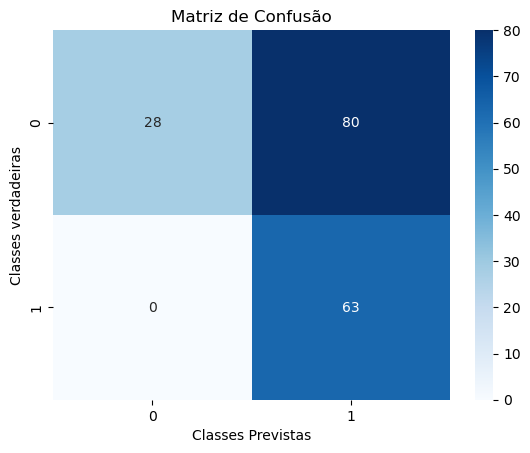

In [39]:
# Avaliar e prever
y_pred_9 = (mlp_model_9.predict(X_test) > 0.5).astype("int32")
accuracy_9 = accuracy_score(y_test_encoded, y_pred_9)
precision_9 = precision_score(y_test_encoded, y_pred_9, zero_division=1)
recall_9 = recall_score(y_test_encoded, y_pred_9)
f1_9 = f1_score(y_test_encoded, y_pred_9)

# Exibir as métricas
print("Accuracy_9:", accuracy_9)
print("Precision_9:", precision_9)
print("Recall_9:", recall_9)
print("F1 Score_9:", f1_9)

# Matriz de confusão
cm = confusion_matrix(y_test_encoded, y_pred_9)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Classes Previstas')
plt.ylabel('Classes verdadeiras')
plt.show()


### 2. Tabela Comparativa dos Modelos

In [47]:
resultados = {
    'Modelo': ['1. MLP com Adam', '2. MLP com SGD', '3. MLP com RMSprop', '4. MLP com Adam + Dropout',
               '5. MLP com Adam + L2', '6. MLP com SGD + Dropout', '7. MLP com SGD + L2', 
               '8. MLP com RMSprop + Dropout', '9. MLP com RMSprop + L2'],
    'Acurácia': [accuracy_1, accuracy_2, accuracy_3, accuracy_4, accuracy_5, accuracy_6, accuracy_7, accuracy_8, accuracy_9],
    'Precisão': [precision_1, precision_2, precision_3, precision_4, precision_5, precision_6, precision_7, precision_8, precision_9],
    'Recall': [recall_1, recall_2, recall_3, recall_4, recall_5, recall_6, recall_7, recall_8, recall_9],
    'F1-Score': [f1_1, f1_2, f1_3, f1_4, f1_5, f1_6, f1_7, f1_8, f1_9]
}

# Criar DataFrame
df_resultados = pd.DataFrame(resultados)


In [49]:
print(df_resultados)

                         Modelo  Acurácia  Precisão    Recall  F1-Score
0               1. MLP com Adam  0.871345  0.825397  0.825397  0.825397
1                2. MLP com SGD  0.368421  0.368421  1.000000  0.538462
2            3. MLP com RMSprop  0.415205  0.386503  1.000000  0.557522
3     4. MLP com Adam + Dropout  0.906433  0.885246  0.857143  0.870968
4          5. MLP com Adam + L2  0.842105  0.730769  0.904762  0.808511
5      6. MLP com SGD + Dropout  0.631579  1.000000  0.000000  0.000000
6           7. MLP com SGD + L2  0.631579  1.000000  0.000000  0.000000
7  8. MLP com RMSprop + Dropout  0.713450  0.562500  1.000000  0.720000
8       9. MLP com RMSprop + L2  0.532164  0.440559  1.000000  0.611650


##  3. Comparação de Modelos com Testes Estatísticos

### 3.1. Distribuição dos dados

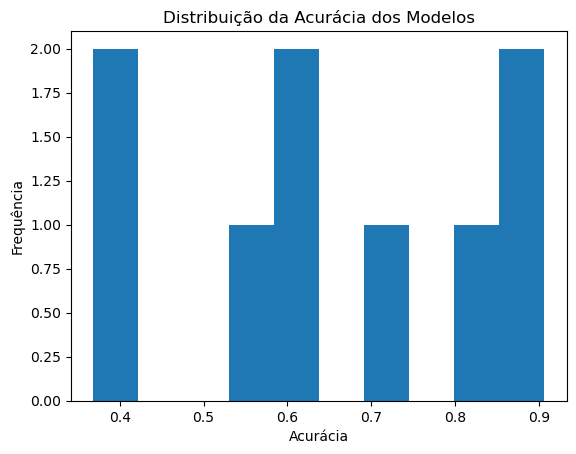

In [69]:
import matplotlib.pyplot as plt

#utilizando os resultados das acurácias
accuracy_results = [accuracy_1, accuracy_2, accuracy_3, accuracy_4, accuracy_5, accuracy_6, accuracy_7, accuracy_8, accuracy_9]

plt.hist(accuracy_results, bins=10)
plt.title("Distribuição da Acurácia dos Modelos")
plt.xlabel("Acurácia")
plt.ylabel("Frequência")
plt.show()


O histograma não possui uma distribuição em forma de sino, que é característica de uma distribuição normal. Em vez disso, ele apresenta um formato que pode ser descrito como bimodal, onde há duas alturas principais nos intervalos de 0.4-0.5 e 0.8-0.9, sugerindo duas concentrações distintas de resultados de acurácia.

OBS: O teste de Shapiro-Wilk também pode ser utilizado para verificar a distribuição dos dados para analisar se a distribuição é normal. Porém neste notebook, devido a amostra pequena dos dados, o teste pode não ser tão eficaz.

Exemplo de implementação, considerado que as acurácias estão devidamente armazenadas em *accuracy_results*:

```python
from scipy.stats import shapiro

# Executar o teste de Shapiro-Wilk
stat, p_value = shapiro(accuracy_results)
print(f"P-valor do teste de Shapiro-Wilk: {p_value}")

if p_value < 0.05:
    print("Os dados não seguem uma distribuição normal.")
else:
    print("Os dados seguem uma distribuição normal.")


Se os dados não forem normais, é recomendável usar testes não-paramétricos, como o **teste de Friedman**.

### 3.2. Teste de Friedman

O Teste de Friedman é um teste não-paramétrico utilizado para comparar dados amostrais vinculados, ou
seja, quando o mesmo indivíduo é avaliado mais de uma vez.

Se o p-value for menor que 0.05, há uma diferença significativa entre os modelos.

In [65]:
from scipy.stats import friedmanchisquare

# Exemplo: resultados de acurácia para 3 modelos em diferentes datasets
stat, p_value = friedmanchisquare([accuracy_1, accuracy_4, accuracy_5], 
                                  [accuracy_2, accuracy_6, accuracy_7], 
                                  [accuracy_3, accuracy_8, accuracy_9])

print(f"P-value para o teste de Friedman (Acurácia): {p_value}")

if p_value < 0.05:
    print("Há uma diferença significativa entre os modelos.")
else:
    print("Não há uma diferença significativa entre os modelos.")


P-value para o teste de Friedman (Acurácia): 0.09697196786440515
Não há uma diferença significativa entre os modelos.


**Isso é tudo pessoal!!!**

*adrielferreira28@gmail.com* | *[GIT](https://github.com/Adrielson)* | *[LinkedIn](https://www.linkedin.com/in/adrielson-justino).*